Деревья решений

## <center>Теория <a class="anchor" id="theory"></a><center>

## Деревья решений<a class="anchor" id="dt"></a>

Далее речь пойдет еще об одном популярном методе машинного обучения - _деревьях решений_. Это семейство алгоритмов значительно отличается от линейных моделей, но применяется также в задачах классификации и регрессии.

Метод основан на известной структуре данных - деревьях, которые по сути представляют собой последовательные инструкции с условиями. Например, в обсуждаемой ранее задаче кредитного скоринга может быть следующий алгоритм принятия решения:

1. Старше ли клиент 18 лет? Если да, то продолжаем, иначе отказываем в кредите.

2. Превышает ли его заработок 50 тысяч рублей? Если да, то продолжаем, иначе отказываем в кредите.

3. Были ли у клиента просроченные кредиты ранее? Если да, отказываем в кредите, иначе выдаем.

В листьях (терминальных узлах) деревьев стоят значения целевой функции (прогноз), а в узлах - условия перехода, определяющие, по какому из ребер идти. Если речь идет о бинарных деревьях (каждый узел производит ветвление на две части), обычно, если условие в узле истинно, то происходит переход по левому ребру, если ложно, то по правому. Изобразим описанный выше алгоритм в виде дерева решений.

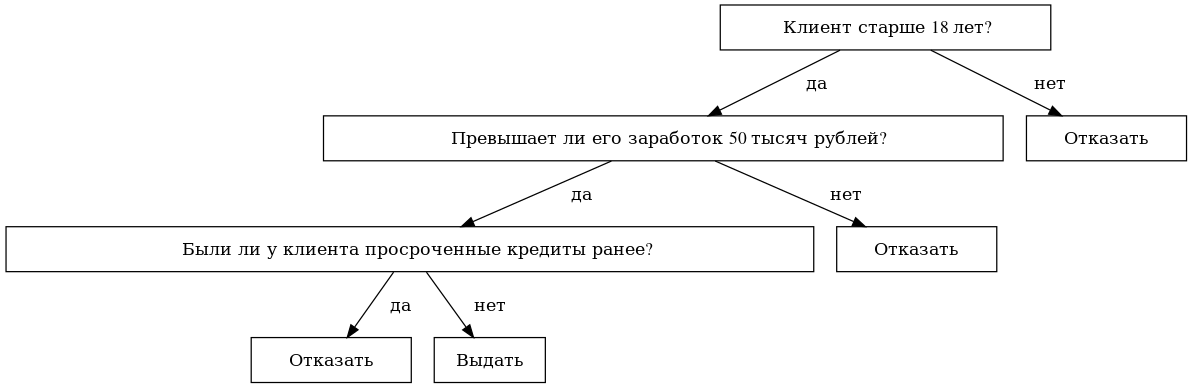

В задачах машинного обучения чаще всего в вершинах прописываются максимально простые условия. Обычно это сравнение значения одного из признаков $x^{j}$ с некоторым заданным порогом $t$:

$$[x^{j} \leq t].$$

Если решается задача классификации, конечным прогнозом является класс или распределение вероятностей классов. В случае регрессии прогноз в листе является вещественным числом.

Большим плюсом деревьев является тот факт, что они легко интерпретируемы.

## Построение деревьев решений<a class="anchor" id="build_dt"></a>

Деревья обладают и отрицательными качествами - в частности, они очень легко переобучаются. Легко построить дерево, в котором каждый лист будет соответствовать одному объекту обучающей выборки. Оно будет идеально подогнано под обучающую выборку, давать стопроцентный ответ на ней, но при этом не будет восстанавливать оригинальных закономерностей, и качество ответов на новых данных будет неудовлетворительным.

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

В машинном обучении деревья строятся последовательно от корня к листьям (так называемый "жадный" способ). Вначале выбирается корень и критерий, по которому выборка разбивается на две. Затем то же самое делается для каждого из потомков этого корня и так далее до достаточного уровня ветвления. Задача состоит в выборе способа **разбиения каждого из узлов**, то есть в выборе значения порога, с которым будет сравниваться значение одного из признаков в каждом узле.

Разбиение выбирается с точки зрения некоторого заранее заданного функционала качества $Q(X, j, t)$. Находятся наилучшие значения $j$ и $t$ для создания _предиката_ $[x^{j}<t]$. **Параметры $j$ и $t$ можно выбирать перебором**: признаков конечное число, а из всех возможных значений порога $t$ можно рассматривать только те, при которых получаются различные разбиения на две подвыборки, таким образом, различных значений параметра $t$ будет столько же, сколько различных значений признака $x^{j}$ в обучающей выборке.


В каждой вершине производится проверка, не выполнилось ли некоторое условие останова (критерии останова рассмотрим далее), и если оно выполнилось, разбиение прекращается, и вершина объвляется листом, и он будет содержать прогноз.

В задаче _классификации_ это будет класс, к которому относится большая часть объектов из выборки в листе $X_{m}$

$$a_{m} = \text{argmax}_{y \in Y} \sum_{i \in X_{m}}[y_{i}=y]$$

или доля объектов определенного класса $k$, если требуется предсказать _вероятности классов_

$$a_{mk} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}[y_{i}=k].$$


In [ ]:
df = pd.read_csv('cardio.csv', sep=';')

features = ['age', 'gender', 'height']
target = ['cardio']
df = df.iloc[:5][features + target]
df

FileNotFoundError: [Errno 2] No such file or directory: 'cardio.csv'

In [ ]:
dt_clsf = DecisionTreeClassifier(random_state=1,
                                 max_depth=1)
dt_clsf.fit(df[features], df[target])

fig, ax = plt.subplots(figsize=(5, 3))
plot_tree(dt_clsf, ax=ax, feature_names=list(features), class_names=['0', '1'], fontsize = 9, filled=True, impurity=False);

В случае _регрессии_ можно в качестве ответа давать средний по выборке в листе

$$a_{m} = \frac{1}{|X_{m}|} \sum_{i \in X_{m}}y_{i}.$$

После построения дерева может проводиться его _стрижка_ (pruning) - удаление некоторых вершин согласно некоторому подходу с целью понижения сложности модели и повышения обобщающей способности.

In [ ]:
dt_regr = DecisionTreeRegressor(random_state=1,
                                max_depth=1)

features = ['cardio', 'gender', 'height']
target = ['age']

dt_regr.fit(df[features], df[target])

fig, ax = plt.subplots(figsize=(5, 3))
plot_tree(dt_regr, ax=ax, feature_names=list(features),fontsize = 9, filled=True, impurity=False);

За функционал качества при работе с деревом решений принимается функционал вида

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

его еще называют **приростом информации** (information gain).

где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - _критерий информативности_. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в $X$, соответственно, задача обучения состоит в его минимизации и, соответственно, максимизации $Q(X_{m}, j, t)$ на данном шаге. Последний, по сути, характеризует прирост качества на данном шаге.

В формуле значения критериев информативности нормируются - домножаются на долю объектов, ушедших в соответствующее подмножество. Например, если у нас множество в узле разбилось на два подмножества размером в 9990 объектов и 10 объектов, но при этом в первом подмножестве все объекты будут принадлежать к одному классу (то есть иметь минимальное значение разброса), а во втором - к разным, то в целом разбиение будет считаться хорошим, так как подавляющее большинство отсортировано правильно.

### Критерий информативности<a class="anchor" id="criterion"></a>

В задаче **классификации** есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Энтропийный критерий_ или _энтропия Шеннона_ :

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

_Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

**Энтропия и деревья принятия решений**

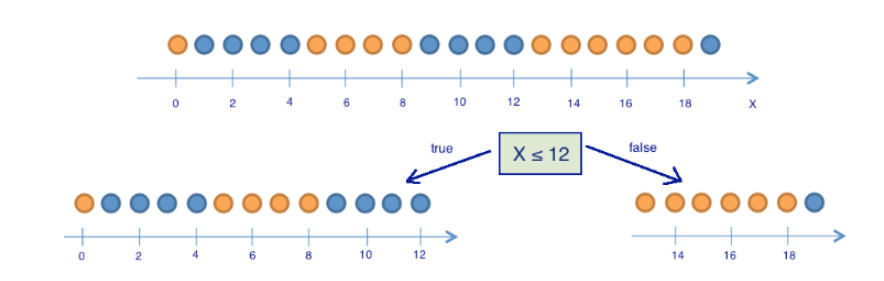

In [ ]:
blue = 9
yellow = 11
total = blue + yellow

p_blue = blue / total
p_yellow = yellow / total
p_blue, p_yellow

In [ ]:
e0 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e0

Энтропия левой группы:

In [ ]:
blue = 8
yellow = 5
total1 = blue + yellow

p_blue = blue / total1
p_yellow = yellow / total1
p_blue, p_yellow

In [ ]:
e1 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e1

Энтропия правой группы:

In [ ]:
blue = 1
yellow = 6
total2 = blue + yellow

p_blue = blue / total2
p_yellow = yellow / total2
p_blue, p_yellow

In [ ]:
e2 = - (p_blue * np.log2(p_blue) + p_yellow * np.log2(p_yellow))
e2

In [ ]:
ig = e0 - total1 / total * e1 - total2 / total * e2
ig

**Реализуем критерий информативности Джини**

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [ ]:
# Расчет критерия Джини
def gini(labels):
    labels = list(labels)

    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    gini = 1
    for label in classes:
        p = classes[label] / len(labels)
        gini -= p ** 2

    return gini

In [ ]:
def gini(labels):
    labels = list(labels)
    set_labels = set(labels)

    gini = 1
    for label in set_labels:
        p = labels.count(label) / len(labels)
        gini -= p ** 2

    return gini

In [ ]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
gini0 = gini(df['cardio'])
gini0

In [ ]:
t = 50.5

In [ ]:
df1 = df[df['age'] <= t]
df2 = df[df['age'] > t]

In [ ]:
df1

In [ ]:
gini(df1['cardio'])

In [ ]:
df2

In [ ]:
gini(df2['cardio'])

In [ ]:
features

In [ ]:
features = ['age', 'gender', 'height']
fig, ax = plt.subplots(figsize=(5, 3))
plot_tree(dt_clsf, feature_names=list(features), class_names=['0', '1'],fontsize = 9, filled=True, impurity=True);
plt.show()

In [ ]:
gain(df1['cardio'], df2['cardio'], gini0)

В случае **регрессии** разброс будет характеризоваться дисперсией или же *среднеквадратичным отклонением*, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

или же *среднеабсолютным отклонением*:

$$H(X) = \frac{1}{X}\sum_{i\in X}(|y_{i} - \bar{y}(X)|),$$


где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

**Реализуем критерий информативности среднеквадратичного отклонения**

In [ ]:
def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

mse(df['age'])

In [ ]:
df1 = df[df['cardio'] <= 0.5]

In [ ]:
df1

In [ ]:
mse(df1['age'])

In [ ]:
df2 = df[df['cardio'] > 0.5]

In [ ]:
mse(df2['age'])

In [ ]:
df2

In [ ]:
features = ['cardio', 'gender', 'height']
fig, ax = plt.subplots(figsize=(5, 3))
plot_tree(dt_regr, feature_names=list(features), filled=True, impurity=True);

In [ ]:
gain(df1['age'], df2['age'], mse(df['age']))

### Критерии останова<a class="anchor" id="stop"></a>

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе.


- Останов в случае, когда все объекты в листе относятся к одному классу.


Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

## Реализация дерева решений<a class='anchor' id='implement_dt'>

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [ ]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2,
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

In [ ]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(4,4))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [ ]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [ ]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [ ]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    min_samples_leaf = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
               continue

            current_gain = gain(true_labels, false_labels, root_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [ ]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, depth=0, leaf_count=[0], max_leaf_nodes=10, min_samples_leaf=2, max_depth=10, alpha=0.01):

    if leaf_count[0] >= max_leaf_nodes:
        return None

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if (depth >= max_depth or
        gain < alpha):
        leaf_count[0]+=1
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)


    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth+1, leaf_count, max_leaf_nodes, min_samples_leaf, max_depth, alpha)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, depth+1, leaf_count, max_leaf_nodes, min_samples_leaf, max_depth, alpha)

#     print(time.time(), false_branch)

    if true_branch is None and false_branch is None:
        leaf_count[0] += 1
        return Leaf(labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

NameError: name 'classification_data' is not defined

In [ ]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

print_tree(my_tree)

In [ ]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

In [ ]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

In [ ]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (8, 4))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [ ]:
visualize(train_data, test_data)

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

### Пример с датасетом сердечно-сосудистых заболеваний

In [ ]:
df_full = pd.read_csv('cardio.csv', sep=';')

features = ['age', 'height']
target = ['cardio']

df = df_full[features + target]
print(df.shape)

train_data, test_data, train_labels, test_labels = train_test_split(df[features].values,
                                                                    np.squeeze(df[target].values),
                                                                    test_size=0.3,
                                                                    random_state=1)

FileNotFoundError: [Errno 2] No such file or directory: 'cardio.csv'

In [ ]:
%%time

my_tree = build_tree(train_data, train_labels)

In [ ]:
print_tree(my_tree)

In [ ]:
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

In [ ]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

In [ ]:
%%time
visualize(train_data, test_data)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(train_data, train_labels)

train_answers = dt.predict(train_data)
test_answers = dt.predict(test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

In [ ]:
accuracy_score(train_answers, train_labels) * 100

## Работа деревьев в случае пропущенных значений<a class='anchor' id='nan'>

Иногда в реальных задачах бывает так, что не для всех объектов известно значение того или иного признака. Одним из преимуществ деревьев решений является возможность обрабатывать такие случаи.

Допустим, требуется вычислить функционал качества для разбиения $[x_{j} \leq t]$, но в выборке $X_{m}$ для некоторого подмножества объектов $V_{j}$ неизвестно значение $j$-го признака. В этом случае функционал качества рассчитывается без учета этих объектов (обозначим выборку без их учета как $X_{m}\text{\ }V_{j}$), с поправкой на потерю информации:

$$Q_{X_{m}, j, t} = \frac{|X_{m}\text{\ } V_{j}|}{|X_{m}|}Q(X_{m}\text{\ }V_{j}, j,t).$$

Если такое разбиение окажется лучшим, объекты из $V_{j}$ помещаются в оба образованных поддерева.

На этапе применения дерева выполняется похожая операция. Если объект попал в вершину, в которой нельзя вычислить критерий разбиения из-за отсутствия значения необходимого признака, прогнозы для него вычисляются в обоих поддеревьях, а затем усредняются с весами, пропорциональными числу объектов в них.

$$\frac{|X_{l}|}{|X_{m}|}a_{l}(x) + \frac{|X_{r}|}{|X_{m}|}a_{r}(x),$$

где $a$ - прогноз веорятности отнесения объекта $x$ к одному из классов.

**Добавим в выборку пропущенные значения**

In [ ]:
random_indices = np.random.randint(0, df.shape[0], 1000)
df.loc[random_indices, ['height']] = np.nan
df.isna().sum()

NameError: name 'df' is not defined

**Получим значения критерия Джини**

In [ ]:
root_gini = gini(df['cardio'])
root_gini

In [ ]:
t = df['height'].median()

df_clean = df[~df['height'].isna()]

In [ ]:
df1 = df_clean[df_clean['height'] <= t]
df2 = df_clean[df_clean['height'] > t]

In [ ]:
gini1 = gini(df1['cardio'])
gini2 = gini(df2['cardio'])
gini1, gini2

**Получим значение прироста информации**

In [ ]:
current_gain = gain(df1['cardio'], df2['cardio'], root_gini)
current_gain

**Сделаем поправку на потерю информации**

In [ ]:
df_clean.shape[0] / df.shape[0] * current_gain

**Если разбиение лучшее, то наблюдения с nan добавляются в обе ветки**

In [ ]:
df1 = pd.concat(df1, df[df['height'].isna()])
df2 = pd.concat(df2, df[df['height'].isna()])

NameError: name 'df1' is not defined

## Работа деревьев с категориальными признаками<a class='anchor' id='cats'>

Кроме вещественных и бинарных признаков в задаче могут иметь место категориальные признаки (делящиеся на конечное число категорий, например, цвета автомобилей). Самый простой способ учета категориальных признаков в алгоритме деревьев состоит в разбитии вершины на столько поддеревьев, сколько имеется возможных значений признака. В этом случае дерево называется _n-арным_. Условие разбиения будет простым (отнесение признака к той или иной категории), однако здесь появляется риск получения конечного дерева с очень большим числом листьев. В случае такого дерева критерий ошибки $Q$ будет состоять из $n$ слагаемых (или из $(n+1)$) в случае максимизируемого критерия, который мы использовали.

Есть и другой подход, заключающийся в формировании бинарных деревьев путем разделения множества значений признака $C = \{c_{1}, ...,c_{n}\}$ на два непересекающихся подмножества $C_{1}$ и $C_{2}$. После такого разделения условием разбиения в узле будет проверка принадлежности признака одному из подмножеств $[x \in C_{1}]$.

Задача остается в выборе оптимального варианта разбиения исходного множества на два подмножества, так как обычный перебор всех вариантов может быть крайне затруднительным из-за большого количества вариантов разбиения. В случаях с бинарной классификацией и регрессией используют следующий метод: все возможные значения категориального признака сортируются по определенному принципу, затем заменяются на натуральные числа.

В случае бинарной классификации признаки упорядочиваются на основе того, какая доля объектов с такими признаками относится к классу +1. Если обозначить множество объектов в узле $m$, у которых $j$-й признак имеет значение $с$, через $X_{m}(c)$, а через $N_{m}(c)$ количество таких объектов, получим:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}[y_{i}=+1]\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}[y_{i}=+1],$$

и после замены категории $c_{i}$ на натуральное число ищется разбиение как для вещественного признака.

В случае задачи регрессии сортировка происходит схожим образом, но вместо доли объектов положительного класса среди объектов с таким значением признака вычисляется средний ответ по объектам с соответствующим значением категориального признака:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}y_{i}\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}y_{i}.$$

**Для классификации**

In [ ]:
colors = ['gray', 'blue', 'green']
new_feature = []
for i in range(df.shape[0]):
    new_feature.append(np.random.choice(colors, p=['0.5', '0.2', '0.3']))

df['eye_color'] = new_feature

df

NameError: name 'df' is not defined

In [ ]:
df[df['cardio'] == 1]['eye_color'].value_counts()

In [ ]:
df['eye_color'].replace({'gray': 3, 'green': 2, 'blue': 1})

**Для регрессии**

In [ ]:
df.groupby('eye_color').mean()['age'].sort_values(ascending=False)

NameError: name 'df' is not defined

In [ ]:
df['eye_color'].replace({'gray': 1, 'green': 3, 'blue': 2})

In [ ]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class LeafReg:
    def __init__(self, labels):
        self.prediction = self.predict(labels)

    def predict(self, labels):
        return labels.mean()


In [ ]:
def dev(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [ ]:
def dev_gain(true_labels, false_labels, labels):
    p = len(true_labels) / len(labels)
    return dev(labels) - (p * dev(true_labels) + (1 - p) * dev(false_labels))

In [ ]:
def find_best_split_for_reg(data, labels, min_samples_leaf=2):
    best_gain = 0
    best_index = None
    best_t = None

    for index in range(data.shape[1]):
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_labels) <= min_samples_leaf  or len(false_labels) <= min_samples_leaf:
                continue

            current_gain = dev_gain(true_labels, false_labels, labels)

            if current_gain > best_gain:
                best_gain, best_index, best_t = current_gain, index, t

    return best_gain, best_t, best_index

In [ ]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree_reg(data, labels, depth=0, leaf_count=[0], max_leaf_nodes=200, min_samples_leaf=4, max_depth=10, alpha=0.01):

    if leaf_count[0] >= max_leaf_nodes:
        return None

    gain, t, index = find_best_split_for_reg(data, labels, min_samples_leaf)

    if (depth >= max_depth or
        gain < alpha):
        leaf_count[0]+=1
        return LeafReg(labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree_reg(true_data, true_labels, depth+1, leaf_count, max_leaf_nodes, min_samples_leaf, max_depth, alpha)
    false_branch = build_tree_reg(false_data, false_labels, depth+1, leaf_count, max_leaf_nodes, min_samples_leaf, max_depth, alpha)

    if true_branch is None or false_branch is None:
        leaf_count[0] += 1
        return LeafReg(labels)

    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object_reg(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, LeafReg):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object_reg(obj, node.true_branch)
    else:
        return classify_object_reg(obj, node.false_branch)

In [ ]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object_reg(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
def error_calc(predictions, true_labels):
    error = np.mean((np.array(predictions) - np.array(true_labels)) ** 2)
    return error

In [ ]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

data, labels = make_regression(n_samples=1000, n_features=2, noise=0.1, random_state=42)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.3, random_state=36)

tree = build_tree_reg(train_data, train_labels)

predictions = predict(test_data, tree)
predictions_train = predict(train_data, tree)

mse_score = error_calc(predictions, test_labels)
mse_score_train = error_calc(predictions_train, train_labels)

print(mse_score)
print(mse_score_train)

18.43887812878756
7.946699540276617
